<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch%20Applstra_%E4%BA%88%E6%B8%AC%E7%B5%90%E6%9E%9C%E3%82%921%E3%81%A4%E3%81%9A%E3%81%A4%E8%A1%A8%E7%A4%BA(%E4%B8%8D%E6%AD%A3%E8%A7%A3%E3%81%AE%E3%81%BF%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#予測結果を1つずつ表示する

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
class pycolor:
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    PURPLE = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    RETURN = '\033[07m' #反転
    ACCENT = '\033[01m' #強調
    FLASH = '\033[05m' #点滅
    RED_FLASH = '\033[05;41m' #赤背景+点滅
    END = '\033[0m'

#Google colabをマウント

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#モデルのロード

In [4]:
# モデルの設定
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device) #model_ftをGPUに載せる

# 重みロード
PATH = '/content/drive/My Drive/Deep_learning/applstra/applstra.pth'
model_ft.load_state_dict(torch.load(PATH))

#評価モードにする
model_ft.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 46.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
#モデルのサマリー（省略可）
from torchsummary import summary
summary(model_ft, (3, 224, 224))

#画像とラベル表示のための関数を定義

In [0]:
#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      print('Image: '+ image_name)
      label = os.path.basename(os.path.dirname(image_path))
      print('Label: '+ label)
      return(image_name, label)

'''
#変形後の画像を表示
def image_transform(image_path):

    image=Image.open(image_path)

    
    #変形した画像を表示する
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
    image_transformed = transform(image)
    plt.imshow(np.array(image_transformed))
'''

#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)

#モデルにした処理した画像を投入して予測結果を表示
def image_eval(image_tensor, label):
    output = model_ft(Variable(image_tensor))
    #print(output.size())  # torch.Size([1, 1000])
    #print(output)

    #正解は青色、不正解は赤色で表示する
    _, pred = torch.max(output, 1)

    if label == class_name[pred]:
        print(pycolor.BLUE+ 'Predicted: '+ class_name[pred] +pycolor.END)
        ans = 'correct'
    if label != class_name[pred]:
        print(pycolor.RED+ 'Predicted: '+ class_name[pred] +pycolor.END)
        ans = 'incorrect'

    return(ans)  #class_nameの番号で出力される

def showResult(image_path):
    #画像のインポート
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #画像のリサイズ
    height = img.shape[0]
    width = img.shape[1]
    resized_img = cv2.resize(img, (int(width*300/height), 300))
    cv2_imshow(resized_img)


#メインプログラム



In [7]:
#ファイル名の取得
image_path = glob.glob("/content/drive/My Drive/Deep_learning/applstra/val/*/*")
print(len(image_path))
print(image_path)

#対象画像のパスからラベルを抜き出す


#ファイル名よりラベルを抜き出し、'class_name'と定義
class_name = []
class_path = glob.glob('/content/drive/My Drive/Deep_learning/applstra/val/*')
for i in class_path:
    class_name.append(os.path.basename(i))  
print(class_name)

127
['/content/drive/My Drive/Deep_learning/applstra/val/appl/mitukoto--770x507.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/pd_3e7850611c4cf3ea9261cde0e41656c63703be8f.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/mitu--770x513.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/mrk003_1.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/natsuakari.JPG', '/content/drive/My Drive/Deep_learning/applstra/val/appl/P2019047.JPG', '/content/drive/My Drive/Deep_learning/applstra/val/appl/pd_d81aa71d05b502c92a0b0bc2eb59b81060a74d20.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/PED_kajiraretaapple2_TP_V4.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/ph00161251.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/photo-1505872342847-6dbb5e76cd31-768x512_1400x.progressive.jpeg.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/ph_kikuchi_ringo02.jpg', '/content/drive/My Drive/Deep_le

Image: mitukoto--770x507.jpg
Label: appl
Predicted: appl

Image: pd_3e7850611c4cf3ea9261cde0e41656c63703be8f.jpg
Label: appl
Predicted: appl

Image: mitu--770x513.jpg
Label: appl
Predicted: appl

Image: mrk003_1.jpg
Label: appl
Predicted: stra


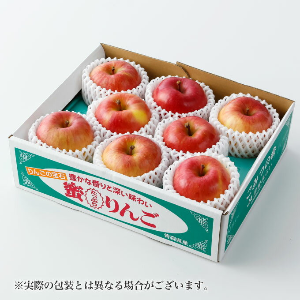


Image: natsuakari.JPG
Label: appl
Predicted: appl

Image: P2019047.JPG
Label: appl
Predicted: appl

Image: pd_d81aa71d05b502c92a0b0bc2eb59b81060a74d20.jpg
Label: appl
Predicted: appl

Image: PED_kajiraretaapple2_TP_V4.jpg
Label: appl
Predicted: appl

Image: ph00161251.jpg
Label: appl
Predicted: appl

Image: photo-1505872342847-6dbb5e76cd31-768x512_1400x.progressive.jpeg.jpg
Label: appl
Predicted: appl

Image: ph_kikuchi_ringo02.jpg
Label: appl
Predicted: appl

Image: ph1_komitsu.jpg
Label: appl
Predicted: appl

Image: prm1908050003-p1.jpg
Label: appl
Predicted: appl

Image: picture_pc_8cc7dcb534e8285786c8f9ba03894a73.jpg
Label: appl
Predicted: appl

Image: photo01.jpg
Label: appl
Predicted: appl

Image: ph_thumb.jpg
Label: appl
Predicted: stra


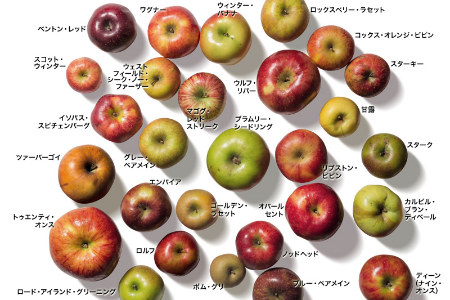


Image: rgn1910240057-p1.jpg
Label: appl
Predicted: appl

Image: publicdomainq-0002607tcr.jpg
Label: appl
Predicted: appl

Image: Red_Apple.jpg
Label: appl
Predicted: appl

Image: ringo-1.jpg
Label: appl
Predicted: appl

Image: ringo-all02.jpg
Label: appl
Predicted: appl

Image: ringo-1024x682.jpg
Label: appl
Predicted: appl

Image: ringo-top.jpg
Label: appl
Predicted: appl

Image: ringo-fuji.jpg
Label: appl
Predicted: appl

Image: ringo-fuji1.jpg
Label: appl
Predicted: appl

Image: ringo-tsugaru.jpg
Label: appl
Predicted: appl

Image: ringo1.jpg
Label: appl
Predicted: appl

Image: ringo08.jpg
Label: appl
Predicted: appl

Image: ringokokuten.jpg
Label: appl
Predicted: appl

Image: ringo1_lp.jpg
Label: appl
Predicted: appl

Image: ringo2-300x225.jpg
Label: appl
Predicted: appl

Image: sd1_2d9932c1aa71bb42067b3bb48e357bb1810a588c.jpg
Label: appl
Predicted: appl

Image: sankotoku.jpg
Label: appl
Predicted: appl

Image: sanfuji5kgy.jpg
Label: appl
Predicted: appl

Image: sd1_aad9f76074b7c1

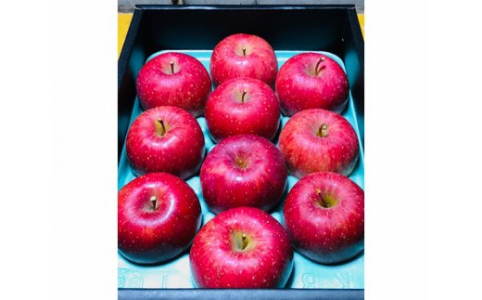


Image: ringohatake.jpg
Label: appl
Predicted: appl

Image: sd1_c8ab8625531af3bdb42243a9171e0cb567871f8b.jpg
Label: appl
Predicted: appl

Image: shutterstock_19154770.jpg
Label: appl
Predicted: appl

Image: sunkakou10top.jpg
Label: appl
Predicted: appl

Image: sk0210062.jpg
Label: appl
Predicted: appl

Image: shutterstock_252604903-690x510.jpg
Label: appl
Predicted: appl

Image: shun_10_02_34.jpg
Label: appl
Predicted: appl

Image: shun_10_02__icat-1100x594.jpg
Label: appl
Predicted: appl

Image: sunhuji--770x513.jpg
Label: appl
Predicted: appl

Image: slider_02.jpg
Label: appl
Predicted: appl

Image: src_11192805.jpg
Label: appl
Predicted: appl

Image: SRxArPn8Ta2F._UX970_TTW__.jpg
Label: appl
Predicted: appl

Image: s_f3b2d3f354f6913add709a56c72d4ff2.jpg
Label: appl
Predicted: appl

Image: title-yukiguni-ringo.jpg
Label: appl
Predicted: appl

Image: town20191011152132.jpg
Label: appl
Predicted: appl

Image: sweet5kgy.jpg
Label: appl
Predicted: appl

Image: tekateka-618x254.jpg
Label:

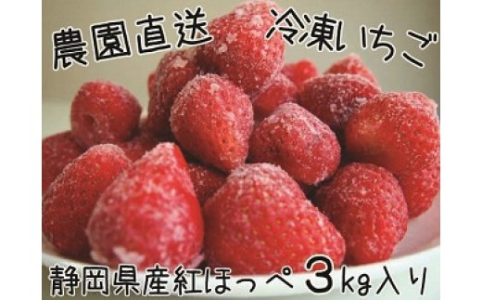


Image: picture_pc_ae52ebd8d46fd8c5e514706f5875bf67.jpg
Label: stra
Predicted: stra

Image: pickup.jpg
Label: stra
Predicted: stra

Image: pd_7fcf162e3bd4e72694f7c84c68bc2f0a78480147.jpg
Label: stra
Predicted: stra

Image: sd1_db1626e1bb33e3caa645872a853b1006bf849414.jpg
Label: stra
Predicted: stra

Image: shironefruits04.jpg
Label: stra
Predicted: stra

Image: slider2.jpg
Label: stra
Predicted: stra

Image: slproImg_201804251817490.jpg
Label: stra
Predicted: stra

Image: shutterstock_410180086cs-1200x630.jpg
Label: stra
Predicted: stra

Image: slider_181220.jpg
Label: stra
Predicted: stra

Image: shironefruits06.jpg
Label: stra
Predicted: stra

Image: sp_image1.jpg
Label: stra
Predicted: stra

Image: smitigo28-top.jpg
Label: stra
Predicted: stra

Image: slproImg_201804251819070.jpg
Label: stra
Predicted: stra

Image: smitigo24-top.jpg
Label: stra
Predicted: stra

Image: sp-img005.jpg
Label: stra
Predicted: stra

Image: sp_sec01.jpg
Label: stra
Predicted: stra

Image: strawberry1634_01

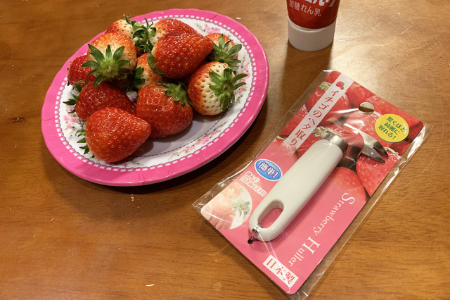


Image: tbm_20191101184911.jpg
Label: stra
Predicted: stra

Image: Strawberry_photo.jpg
Label: stra
Predicted: stra

Image: ti1-1.jpg
Label: stra
Predicted: stra

Image: titleimg.jpg
Label: stra
Predicted: stra

Image: tochigi-ichigo_no_sato001.jpg
Label: stra
Predicted: stra

Image: tochigi_ichigonosato27.jpg
Label: stra
Predicted: stra

Image: top-conD01.jpg
Label: stra
Predicted: stra

Image: top2.jpg
Label: stra
Predicted: stra

Image: top_strawberry_sp.jpg
Label: stra
Predicted: stra

Image: top_about2new.jpg
Label: stra
Predicted: stra

Image: top-image.jpg
Label: stra
Predicted: stra

Image: topimage_new01.jpg
Label: stra
Predicted: stra

Image: top-pic01-2018.jpg
Label: stra
Predicted: stra

Image: top_on_img.jpg
Label: stra
Predicted: stra

Image: top_img_ichigo2019.jpg
Label: stra
Predicted: stra

Image: top_ichigo.jpg
Label: stra
Predicted: stra

Image: top_img02.jpg
Label: stra
Predicted: stra

Image: udoki_u_20190302_02.jpg
Label: stra
Predicted: stra

Image: web_food_phot

In [10]:
for i in image_path:
    image_name, label = getlabel(i)  #画像の名前とラベルを取得
    image_tensor = image_transform(i)  #予測のための画像下処理
    ans = image_eval(image_tensor, label)  #予測結果を表示   
    
    if ans == 'incorrect':
        showResult(i)  #画像を表示
    
    print() #空白行を入れる
    time.sleep(0.1)
    